In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from tqdm import tqdm

import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ConsT

In [19]:
BTC = '../btc_data/BTC.pck'

# DeFS

In [20]:
def get_BTC():
    df = pd.read_pickle(BTC)
    return df

In [21]:
def show_stats(egg, col_epoch='e', col_values='BTC'):
    epoka_stats = egg.groupby(col_epoch)[col_values].agg(['mean', 'min', 'max', 'std', 'median', 'count'])
    
    # Wyświetlenie wynikowej tabeli
    return (epoka_stats)

# MaiN

In [22]:
df = get_BTC()
df.tail(3)

,dfh,e,BTC
2024-11-08,203.0,5,60630.94
2024-11-09,204.0,5,60630.94
2024-11-10,205.0,5,60689.04


In [23]:
egg = show_stats(df)
egg

,mean,min,max,std,median,count
e,,,,,,
1,5.240525,0.04951,29.60,4.877265,4.8605,844
2,337.852427,10.82000,1237.55,227.196627,295.6000,1339
3,5757.937568,513.43000,19345.49,3707.967492,6318.4150,1402
4,32778.438242,8568.88000,73118.09,15532.774170,29907.9800,1439
5,62541.461311,53954.33000,71430.23,3780.369979,61742.1050,206


In [24]:
epoka_stats = df.groupby('e')['dfh'].agg(['mean', 'min', 'max', 'std', 'median', 'count'])
epoka_stats

,mean,min,max,std,median,count
e,,,,,,
1,982.5,561.0,1404.0,243.786108,982.5,844
2,669.0,0.0,1338.0,386.680316,669.0,1339
3,700.5,0.0,1401.0,404.866851,700.5,1402
4,719.0,0.0,1438.0,415.547831,719.0,1439
5,102.5,0.0,205.0,59.611241,102.5,206


In [25]:
egg.columns

Index(['mean', 'min', 'max', 'std', 'median', 'count'], dtype='object')

In [26]:
df.index = pd.to_datetime(df.index)
df['YM'] =df.index.strftime('%y%m')

max_dni = df['dfh'].max()

# Ustalanie binów: 20 równych przedziałów na podstawie maksymalnej wartości dfh
liczba_segmentow = 20
bins = np.linspace(0, max_dni, liczba_segmentow + 1)

# Przypisanie każdego dfh do odpowiedniego binu (segmentu)
df['seg'] = np.digitize(df['dfh'], bins, right=True)


df.head(3)

,dfh,e,BTC,YM,seg
2010-07-18,561.0,1,0.04951,1007,8
2010-07-19,562.0,1,0.08584,1007,8
2010-07-20,563.0,1,0.08080,1007,8


In [27]:
df.groupby(by=['e'])['dfh'].max()

e
1    1404.0
2    1338.0
3    1401.0
4    1438.0
5     205.0
Name: dfh, dtype: float64

In [28]:
df.groupby(by=['e'])['dfh'].min()

e
1    561.0
2      0.0
3      0.0
4      0.0
5      0.0
Name: dfh, dtype: float64

# ------------------

In [41]:
def add_segments(df, HOW_MANY_SEG):
    
    # HOW_MANY_SEG = 20
    
    # Obliczamy maksymalne dfh dla epoki 4
    max_dfh_epoka_4 = df[df['e'] == 4]['dfh'].max()

    # Tworzymy biny dla epoki 4
    bins_epoka_4 = np.linspace(0, max_dfh_epoka_4, HOW_MANY_SEG+1)  # 20 segmentów to 21 granic

    # Funkcja do przypisania segmentów
    def przypisz_segmenty(grupa):
        if grupa['e'].iloc[0] in [2, 3, 4]:  # dla epok 2, 3, 4
            max_dfh = grupa['dfh'].max()
            bins = np.linspace(0, max_dfh, HOW_MANY_SEG)  # 20 segmentów
        else:  # dla epok 1 i 5
            bins = bins_epoka_4  # użyj binów z epoki 4

        grupa['seg'] = np.digitize(grupa['dfh'], bins, right=False)  # przypisz segmenty
        return grupa

    # Grupujemy dane po epokach i stosujemy przypisywanie segmentów
    df = df.groupby('e', group_keys=True).apply(przypisz_segmenty)
    
    df.index = df.index.droplevel('e')
    
    return df

def add_cv(df):
    
    # Obliczenie maksymalnej wartości BTC w kolejnych 30 dniach
    df['BTC_Max_30'] = df['BTC'].rolling(window=15).max()

    # Obliczenie procentowej zmiany dla maksymalnej wartości
    df['pc'] = df['BTC_Max_30'].pct_change()
    
    df['mean'] = df['BTC'].rolling(window=30).mean().shift(-30)  # Średnia w oknie 30 dni
    df['std'] = df['BTC'].rolling(window=30).std().shift(-30)    # Odchylenie standardowe w oknie 30 dni

    # Obliczanie współczynnika zmienności (CV)
    df['CV'] = df['std'] / df['mean']

    # Opcjonalnie: usunięcie tymczasowych kolumn
    df = df.drop(columns=['mean', 'std'])

    df.dropna(inplace=True)
    
    return df

def add_poly(df, DFH, poly_level):
    
    egg = df[df.dfh==DFH]
    
    # Przygotowanie danych
    # Użyjemy oryginalnych indeksów z egg jako zmiennej niezależnej
    X_egg = egg.index.values.reshape(-1, 1)  # Indeks jako zmienna niezależna
    y_egg = egg['BTC'].values                   # Wydobycie zmiennej zależnej (BTC)

    # Tworzenie wielomianowych cech
    poly = PolynomialFeatures(degree=poly_level)
    X_poly = poly.fit_transform(X_egg)

    # Trenowanie modelu regresji
    model = LinearRegression()
    model.fit(X_poly, y_egg)

    # Przygotowanie danych do przewidywania dla df
    X_df = df.index.values.reshape(-1, 1)  # Indeks z df jako zmienna niezależna
    X_df_poly = poly.transform(X_df)        # Przekształcenie na cechy wielomianowe

    # Przewidywanie wartości BTC dla df
    df[f'R_{DFH}_{poly_level}'] = model.predict(X_df_poly)    # Dodanie nowej kolumny 'res' do df
    
    return df

In [56]:
df = get_BTC()
df = add_segments(df, 20)
df['date'] = df.index
df.reset_index(inplace=True, drop=True)
# df = add_cv(df)

# df = df[df.e>3]
# df = df[df.e<51]
df.head(3)

,dfh,e,BTC,seg,date
0,561.0,1,0.04951,8,2010-07-18
1,562.0,1,0.08584,8,2010-07-19
2,563.0,1,0.08080,8,2010-07-20


,dfh,e,BTC,seg,date,R_0_4
5227,203.0,5,60630.94,3,2024-11-08,78798.840159
5228,204.0,5,60630.94,3,2024-11-09,78880.359831
5229,205.0,5,60689.04,3,2024-11-10,78961.942559


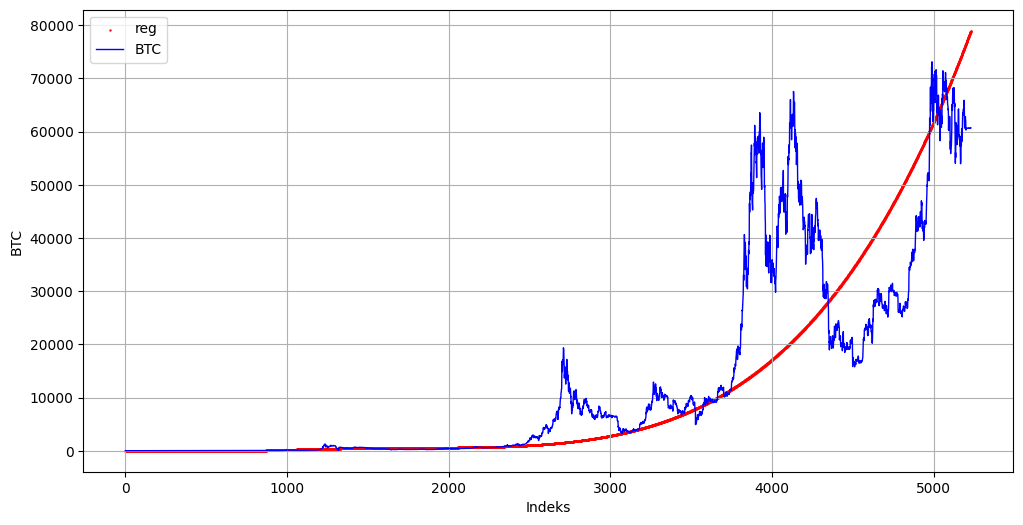

In [86]:
#---------------------------------
dfh = 0
pol_lev = 4
col_name = f'R_{dfh}_{pol_lev}'
#---------------------------------
df = add_poly(df, dfh, pol_lev)
#---------------------------------
df[col_name] = df[col_name].clip(lower=0, upper=df['BTC'].max()*1.1)
#---------------------------------
egg = df
#---------------------------------
# Wizualizacja
plt.figure(figsize=(12, 6))
plt.scatter(x = df.index, y = df[col_name], color='red', label='reg', s=0.5)  # Punkty rzeczywiste
plt.plot(df.index, df['BTC'], color='blue', label='BTC', linewidth=1)  # Krzywa modelu
# plt.plot(df, df['BTC'], color='green', label='Kurs BTC')  # Krzywa modelu
# plt.title('Regresja Wielomianowa BTC')
plt.xlabel('Indeks')
plt.ylabel('BTC')
plt.legend()
plt.grid()
plt.show()

73118.09

# ----- reg 

In [92]:
# Tworzenie kolumny H (ATH) - od początku do końca
df['H'] = (df['BTC'].cummax() == df['BTC']).astype(int)
# Tworzenie kolumny L (ATL) - od końca do początku
df['L'] = (df['BTC'] == df['BTC'].iloc[::-1].cummin().iloc[::-1]).astype(int)

In [93]:
df.head(3)

,dfh,e,BTC,seg,date,R_0_4,R_0_20,R_0_15,R_0_11,R_0_5,R_0_6,R_0_1,R_0_2,R_0_3,H,L
0,561.0,1,0.04951,8,2010-07-18,0.0,10.935307,10.912078,10.605598,0.0,0.0,0.0,18942.269410,0.0,1,1
1,562.0,1,0.08584,8,2010-07-19,0.0,10.935307,10.912078,10.605598,0.0,0.0,0.0,18916.374015,0.0,1,0
2,563.0,1,0.08080,8,2010-07-20,0.0,10.935307,10.912078,10.605598,0.0,0.0,0.0,18890.492325,0.0,0,0
